# **Homework 7:** PyTorch

## Part 1: Introduction to PyTorch

Now that we've successfully built our own tool for automatic differentiation and neural networks, let's look at an industry-standard tool for accomplishing the same tasks: [PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html).

Throughout this homework to may find it helpful to refer to the [PyTorch documentation](https://pytorch.org/docs/stable/index.html), as well as the [lecture notebook on Pytorch](https://colab.research.google.com/drive/1hJoRYXlGT-nRE4LnA9LEjQcy-c2IEy0p?usp=sharing#scrollTo=cmK5TWhhmePR).

We saw in class that we can create a function with *parameters* in PyTorch using the `torch.nn` module that we'll import as just `nn`. We can do this by creating a subclass of `nn.Module` and defining the parameters with `nn.Parameter`.

In [1]:
# Uncomment and run if using Colab!

#import urllib.request
#remote_url = 'https://gist.githubusercontent.com/gabehope/4d66c02805cb1a8b1b1f6043f08c5929/raw/14332b6d752fe1c7420647a2fe7eeb587cd767ef/hw6_support.py'
#with urllib.request.urlopen(remote_url) as remote, open('hw7_support.py', 'w') as local:
#  [local.write(str(line, encoding='utf-8')) for line in remote]


In [2]:
import torch
from torch import nn
from hw7_support import *


class LinearZeros(nn.Module):
    '''
    A PyTorch module representing a linear/affine function with weights W and bias b:
        f(X) = XW + b
    W is an (in_dimensions x out_dimensions) matrix and b is an (out_dimensions) vector.

    This version of the Linear module initializes the parameters to 0.
    '''
    def __init__(self, in_dimensions, out_dimensions):
        # Call the nn.Module __init__ function
        super().__init__()

        # Create parameters that we can fit with gradient descent.
        self.weights = nn.Parameter(torch.zeros(in_dimensions, out_dimensions))
        self.bias = nn.Parameter(torch.zeros(out_dimensions))

    def forward(self, x):
        # Compute the function. Note that we use torch.matmul rather than torch.dot!
        # This assumes X is 2-dimensional (a matrix)!
        return torch.matmul(x, self.weights) + self.bias

We can create a 1-dimensional linear function by creating a `LinearZeros` object, specifying that both the input and output dimensions should be `1`. The method `model.parameters()` will give us access to all the weights we can fit with gradient descent.

In [3]:
model = LinearZeros(1, 1)
list(model.parameters())

[Parameter containing:
 tensor([[0.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

We can also call this model just like any other function.

In [4]:
# Create 4 1-dimensional inputs
x = torch.ones((4, 1))

model(x)

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<AddBackward0>)

Let's start by creating a simple dataset to use for the next few problems. We'll use a regression dataset similar to the one we saw in class. In this case, I've provied data already split into training and validation sets.

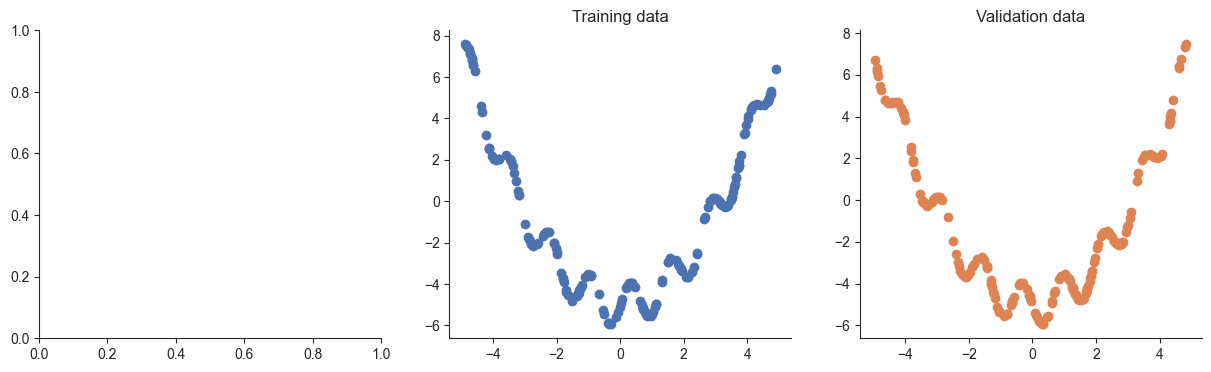

In [5]:
# Create the training inputs and labels
x = torch.rand(200, 1) * 10 - 5.
y = x ** 2 / 2 + torch.sin(x * 5) - 5

# Create the validation inputs and labels
xvalid = torch.rand(200, 1) * 10 - 5.
yvalid = xvalid ** 2 / 2 + torch.sin(xvalid * 5 + torch.pi) - 5

plotRegression(x, y, xvalid, yvalid)

We can make predictions for our data using the model we just definied:

In [6]:
predictions = model(x)
predictions[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)

However if we plot the prediction function, we'll see that it isn't very good as we haven't optimized the parameters yet:

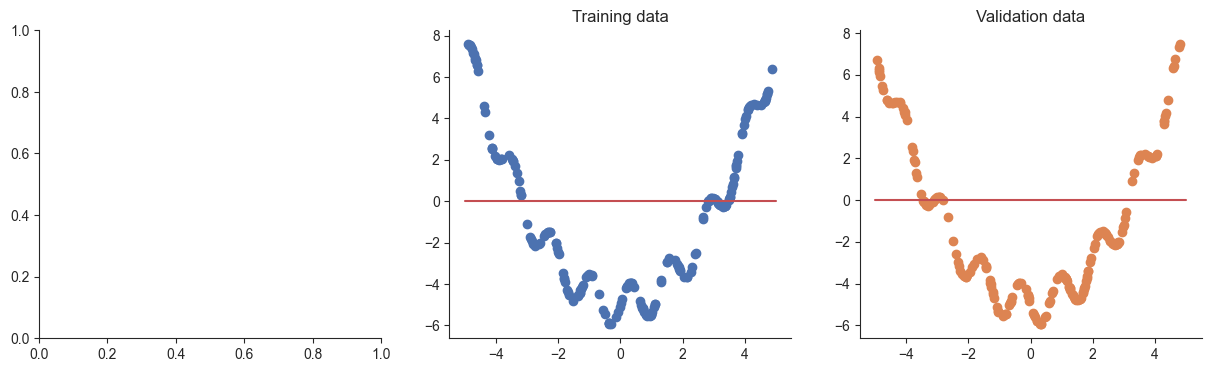

In [7]:
plotRegression(x, y, xvalid, yvalid, model=model)

The first thing we'll need to optimize our model is a loss function. As we saw in class, the convention in PyTorch is to separate the loss from the model, so we'll write a simple function that takes in predictions and labels, returning the *mean squared error* loss.

#### **Q1**

Complete the `mse_loss` function below. The function should compute the same MSE loss we've seen in previous homeworks, but using **PyTorch** operations.

$$\textbf{Loss}(\mathbf{a}, \mathbf{y}) = \frac{1}{N}\sum_{i=1}^N(a_i - y_i)^2$$

***Hint:** As we see above, our linear module returns a **column-vector** (`predictions` is 2-dimensional), but `y` is just a vector (`y` is 1-dimensional). Make sure to account for this!*

#### Answer

In [8]:
def mse_loss(prediction, labels):
    return torch.mean((prediction.reshape((-1,)) - labels.reshape((-1,))) ** 2)


# Test to check
torch.manual_seed(0)
assert torch.isclose(mse_loss(torch.randn(10, 1), torch.randn(10, 1)), torch.tensor(1.1550), 1e-3)

With our loss in hand, we can run gradient descent to optimize our model's parameters. This time, we'll use the `torch.optim` module, which includes many useful variations of gradient descent.

#### **Q2**

Complete the gradient descent function below. The function should:
- Create an `optim.SGD` optimizer for the model's parameters with the specified learning rate
- At each step:
    - Compute the model output and loss (`loss_func`) on the training data
    - Compute the gradients of the loss with respect to the model parameters
    - Take a gradient descent step
    - Reset the parameter gradients to 0
    - Compute the validation loss


#### Answer

In [9]:
from torch import optim

def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        output = model(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        valid_loss = loss_func(model(xvalid), yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

    return losses, valid_losses

# Test our function
test_gradient_descent(gradient_descent, mse_loss, x, y, xvalid, yvalid)

100%|██████████| 1/1 [00:00<00:00, 27.20it/s]

Passed!


100%|██████████| 5000/5000 [00:00<00:00, 10880.02it/s]


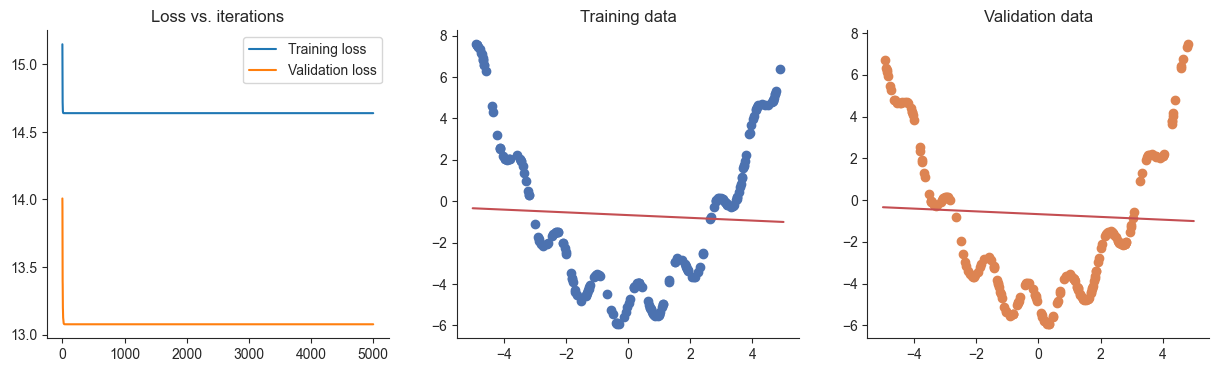

In [10]:
model = LinearZeros(1, 1)
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

Now that we have a function to train a PyTorch model, we can try something bigger and more exciting! Let's train a neural network.

#### **Q3**

Create a PyTorch model for a neural network with the following specification:
- The network should have 4 hidden layers, each with 20 neurons
- The network should take 1-dimensional inputs as above
- Each layer should use the LinearZeros module we just wrote
- Each linear layer should be followed by a *ReLU* activation (except the output), use the `nn.ReLU()` module.

***Hint:** Remember that you can use the `nn.Sequential` class to easily compose a sequence of functions in PyTorch.*

#### Answer

Passed!


100%|██████████| 5000/5000 [00:01<00:00, 3014.51it/s]


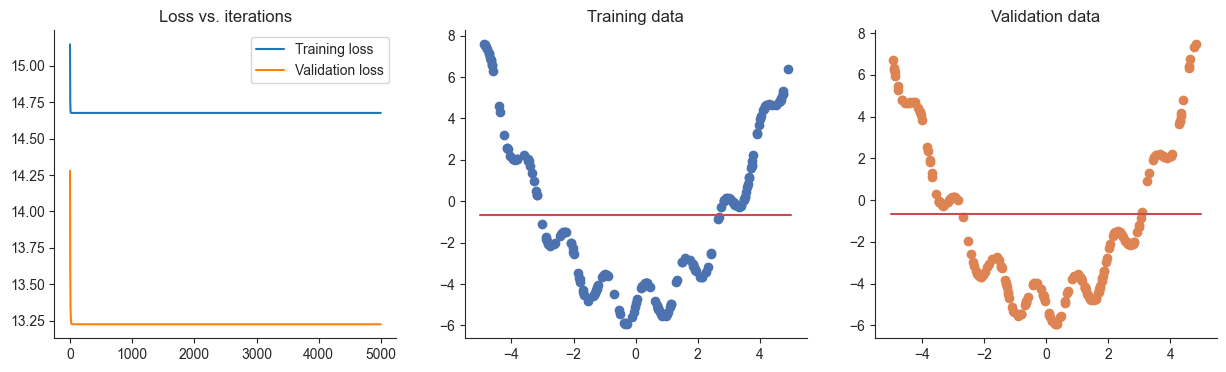

In [11]:
model = nn.Sequential(
            LinearZeros(1, 20),
            nn.ReLU(),
            LinearZeros(20, 20),
            nn.ReLU(),
            LinearZeros(20, 20),
            nn.ReLU(),
            LinearZeros(20, 20),
            nn.ReLU(),
            LinearZeros(20, 1),
            )

# Test the model build
test_build(model, LinearZeros, dropout_type=None, type='zeros')

# Run the model
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)


#### **Q4**

What happened when you attempted to train the model above? Why did this happen? Give a short 1-2 sentence answer.

#### Answer



Nothing happened because we initialized all weights to 0.


Let's try modifying our Linear module with a different strategy for initialization.

#### **Q5**

Modify the `LinearZeros` implementation from above to initialize the `weights` and `bias` parameters from a *standard normal* distribution $w,b \sim \mathcal{N}(0, 1)$. Then modify your model from **Q6** to use this new module.

***Hint:** You may find the `torch.randn` function useful here. You might also find that the model doesn't train! We'll address this in the next question.*

#### Answer

Passed!
Passed!


100%|██████████| 5000/5000 [00:01<00:00, 3333.41it/s]


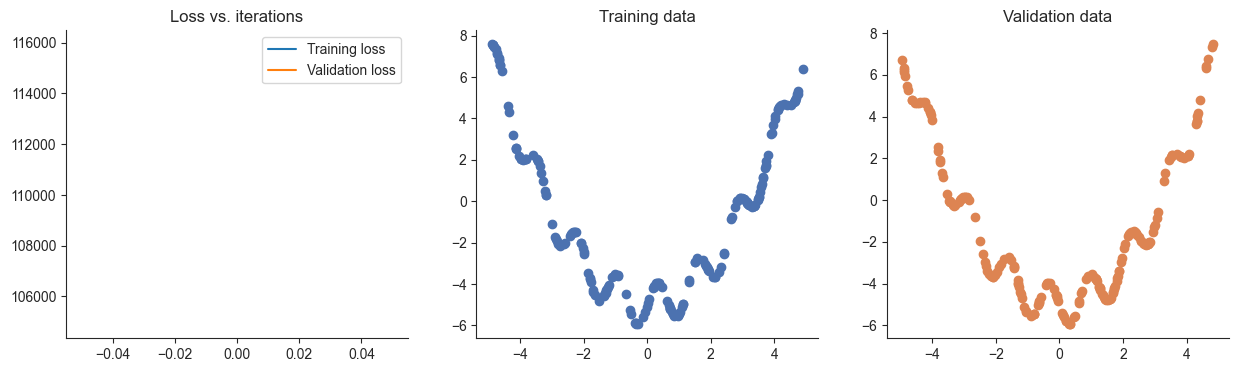

In [12]:
class LinearNormal(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_dimensions, out_dimensions))
        self.bias = nn.Parameter(torch.randn(out_dimensions))

    def forward(self, x):
        return torch.matmul(x, self.weights) + self.bias
    
model = nn.Sequential(
            LinearNormal(1, 20),
            nn.ReLU(),
            LinearNormal(20, 20),
            nn.ReLU(),
            LinearNormal(20, 20),
            nn.ReLU(),
            LinearNormal(20, 20),
            nn.ReLU(),
            LinearNormal(20, 1),
            )

# Test the model build and LinearKaiming
test_normal(LinearNormal)
test_build(model, LinearNormal, dropout_type=None, type='normal')

losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid, lr=0.1)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

#### **Q6**
In the previous question you might have found that gradient descent didn't work. This could suggest that our learning rate is set wrong. Think about a strategy that you might use to find an appropriate learning rate for fitting this model and try it out below. Then explain the strategy that you used. Is there any way you could improve this strategy to make finding a learning rate quicker?

#### Answer

100%|██████████| 5000/5000 [00:01<00:00, 3079.02it/s]


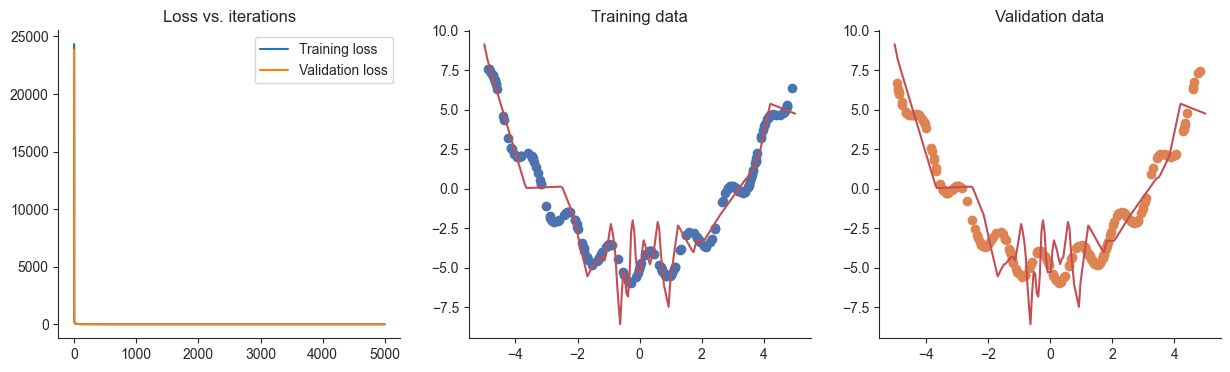

In [13]:
# Modify this code to choose a good learning rate
model = nn.Sequential(
            LinearNormal(1, 20),
            nn.ReLU(),
            LinearNormal(20, 20),
            nn.ReLU(),
            LinearNormal(20, 20),
            nn.ReLU(),
            LinearNormal(20, 20),
            nn.ReLU(),
            LinearNormal(20, 1),
            )

lr = 0.00001
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

#### **Q7**
We saw in class that a common, useful approach for initializing neural networks is to use a *Kaiming normal* initialization. In this approach we draw each initial weight from a normal distribution where the standard deviation is scaled by the square root of the number of input dimensions to the layer. If $\mathbf{W} \in \mathbb{R}^{d\times e}$ then:
$$w_{ij} \sim \mathcal{N}\bigg(0, \frac{1}{\sqrt{d}}\bigg) \quad \mathbf{W}: d \times e$$
$$b_j = 0 \quad \mathbf{b}: e$$
We'll initialize the biases to $0$. Below, implement a linear module using the Kaiming normal initialization, then repeat **Q5** using the `LinearKaiming` class and the learning rate you chose in **Q8**. If needed, adjust the learning rate until your model almost perfectly fits the *training data*.

#### Answer

Passed!
Passed!


100%|██████████| 5000/5000 [00:01<00:00, 3045.19it/s]


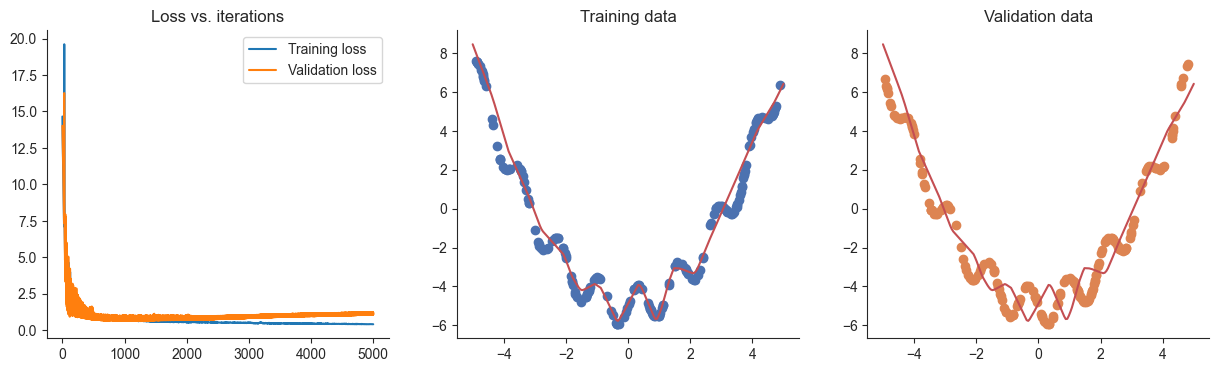

In [14]:
class LinearKaiming(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_dimensions, out_dimensions) / np.sqrt(in_dimensions))
        self.bias =nn.Parameter(torch.zeros(out_dimensions))

    def forward(self, x):
        return torch.matmul(x, self.weights) + self.bias
    
model = nn.Sequential(
            LinearKaiming(1, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 1),
            )

# Test the model build and LinearKaiming
test_kaiming(LinearKaiming)
test_build(model, LinearKaiming, dropout_type=None, type='normal')

lr = 0.01
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

If all went well so far, we should find that our model fits our data well, but perhaps a little bit *too* well. Let's try out some of the strategies we've seen to reduce overfitting, starting with early stopping.

#### **Q8**

Modify your gradient descent algorithm to implment a basic form of early stopping: stop gradient descent as soon as the validation loss increases from the previous iteration. Test this approach with the same model from **Q9**.

#### Answer

  1%|          | 26/5000 [00:00<00:02, 2084.48it/s]


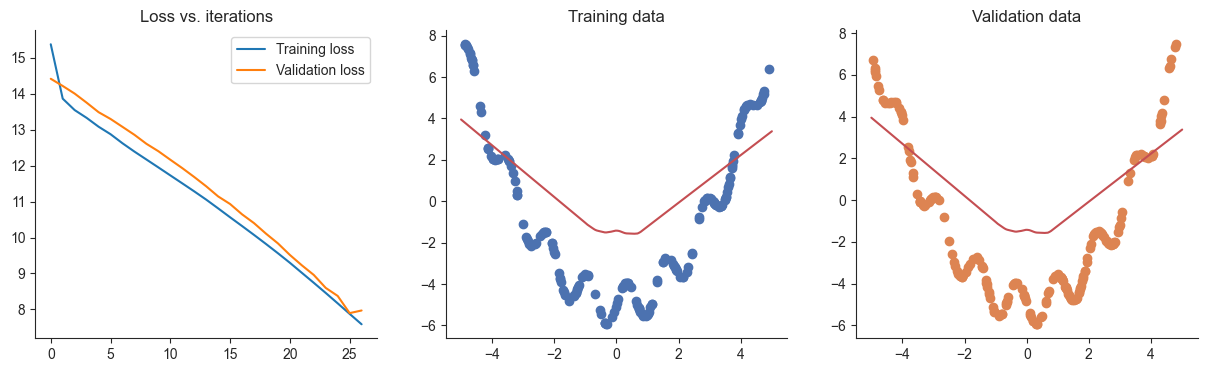

In [15]:
def gradient_descent_early_stopping(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        output = model(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        valid_loss = loss_func(model(xvalid), yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())
        if len(valid_losses) > 1 and valid_losses[-2] < valid_losses[-1]:
            break

    return losses, valid_losses

model = nn.Sequential(
            LinearKaiming(1, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 1),
            )
lr = 0.01
losses, valid_losses = gradient_descent_early_stopping(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

#### **Q9**

Did this approach work as intended? Why or why not? Think about how you might improve this approach and explain any ideas you have in 1-2 sentences.

#### Answer

No, it stopped too early.

#### **Q10**

Modify your early stopping gradient descent so that it always runs for at least 50 iterations. Then after 50 iterations stop if at any point the validation loss is larger than the *average validation loss for the previous 50 iterations*.

#### Answer

  2%|▏         | 105/5000 [00:00<00:02, 2299.35it/s]


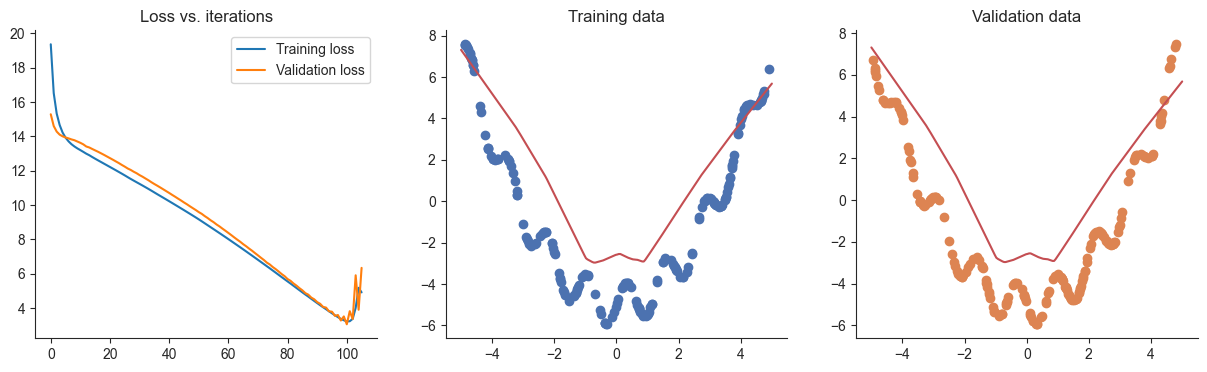

In [16]:
def gradient_descent_patient_early_stopping(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        output = model(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        valid_loss = loss_func(model(xvalid), yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())
        if len(valid_losses) > 50 and np.mean(valid_losses[-50:-1]) < valid_losses[-1]:
            break

    return losses, valid_losses

model = nn.Sequential(
            LinearKaiming(1, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 1),
            )
lr = 0.003
losses, valid_losses = gradient_descent_patient_early_stopping(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

Now let's try out L1 regualrization! We will consider a scaled version of L1 regularization, where for a $d \times e$ weight matrix $\mathbf{W}$ we will define the L1 loss as:
$$\textbf{Loss}_{L1}(\mathbf{W})= \frac{\lambda}{d e}\sum_{i=1}^d\sum_{j=1}^e |w_{ij}| \quad \mathbf{W}: d \times e$$
Here $\lambda$ is a value that we can choose to control how much weight we put on our L1 loss (we'll call it `l1_weight` below).

#### **Q11**

Modify your original gradient descent algorithm from **Q4** (no early stopping) to add the L1 loss for each parameter in the model to the loss.

***Hint:** Recall that we can access every parameter in the model using the `model.parameters()` method. In this question you do not need to worry about distinguishing between weights and biases, you can apply L1 regularization to biases as well if it simplifies your approach. Your validation loss should not include the regularization terms.*

#### Answer

In [17]:
from torch import optim

def gradient_descent_l1(model, loss_func, x, y, xvalid, yvalid, lr=0.1, l1_weight=1., steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        output = model(x)
        loss = loss_func(output, y)
        losses.append(loss.detach().numpy()) 

        l1_loss = 0
        for p in model.parameters():
            l1_loss = l1_loss + torch.mean(torch.abs(p))
        loss = loss + l1_weight * l1_loss        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        valid_loss = loss_func(model(xvalid), yvalid)
        valid_losses.append(valid_loss.detach().numpy())

    return losses, valid_losses

# Test our function
test_gradient_descent(gradient_descent_l1, mse_loss, x, y, xvalid, yvalid, l1=True)

100%|██████████| 1/1 [00:00<00:00, 328.09it/s]

Passed!


#### **Q12**

Apply `gradient_descent_l1` as in previous problems. Find an appropriate setting of `l1_weight` that minimizes the validation loss.

***Hint:** How you go about choosing `l1_weight` is up to you! Your validation loss should be lower than the validation loss without regularization.*


#### Answer

100%|██████████| 5000/5000 [00:02<00:00, 1984.48it/s]


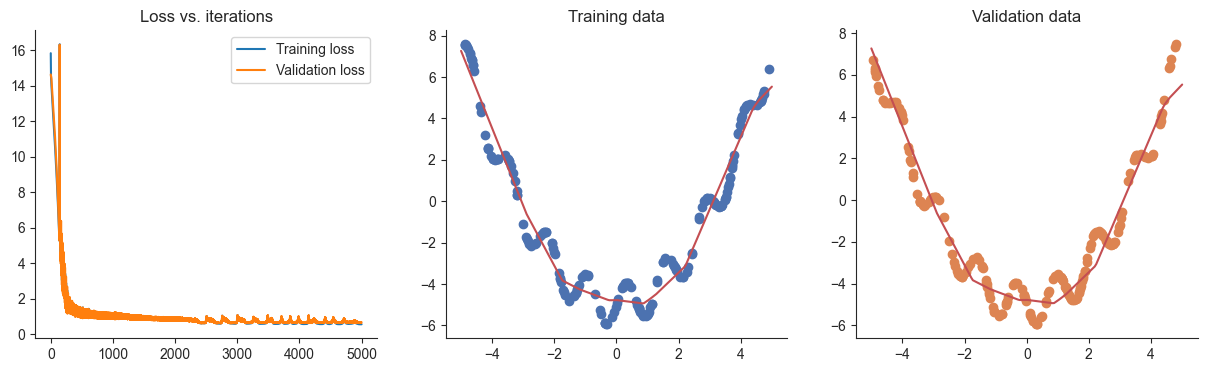

In [18]:
model = nn.Sequential(
            LinearKaiming(1, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            LinearKaiming(20, 1),
            )
lr = 0.003
l1_weight = 1.
losses, valid_losses = gradient_descent_l1(model, mse_loss, x, y, xvalid, yvalid, lr=lr, l1_weight=l1_weight)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)


Finally let's try out *dropout* regularization. We will implement dropout as its own module, so we can think of it as a function that transforms a vector or matix into a vector or matrix of the same shape with elements randomly set to $0$. In this case we can write the dropout function as:
$$\text{Dropout}(\mathbf{X}, r) = \mathbf{D} \odot \mathbf{X}, \quad \mathbf{D} =
\begin{bmatrix}
d_{11} & d_{12} & \dots & d_{1n} \\
d_{21} & d_{22} & \dots & d_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
d_{m1} & d_{m2} & \dots &  d_{mn}
\end{bmatrix},\ d_{ij} \sim \text{Bernoulli}(1-r)$$

Here $\odot$ denotes element-wise multiplication (so $\mathbf{D}$ and $\mathbf{X}$ are the same shape), $r$ is the dropout rate so $p(d_{ij}=0)=r$.

At evaluation time, we do not want to randomly drop elements. Instead we will scale $\mathbf{X}$ by $(1-r)$:
$$\text{Dropout}_{\text{eval}}(\mathbf{X}, r) = (1-r)\mathbf{X}$$

#### **Q13**
Complete the implementation of the `Dropout` module below.

***Hint:** The built-in `training` property of an `nn.Module` instance specifies if our model is in training mode or evaluation mode. By default models are in training mode (`training == True`), but we can set a model to evaluation mode by calling `model.eval()`. Then we can use `model.train()` to set it back to training mode.*

*You may find the function `torch.rand_like()` helpful for this problem. You might also find it helpful to know that you can convert and `boolean` tensor `X` into a `float` tensor by calling `X.float()` (`True` becomes `1.`, `False` becomes `0.`)*

#### Answer

In [20]:
class Dropout(nn.Module):
    def __init__(self, rate=0.01):
        # Rate specifies the dropout rate (r)
        super().__init__()
        self.rate = rate

    def forward(self, x):
        if self.training:
            return x * (torch.rand_like(x) > self.rate).float()
        else:
            return x * (1 - self.rate)
        
test_dropout(Dropout)

Passed!


#### **Q14**

Modify your `gradient_descent` function to put the model into `train` mode before calculating the training loss and into `eval` mode before calculating the validation loss. Then create a model based on your network from **Q9**, but this time add a `Dropout` layer before each `LinearKaiming` layer. You can use the default dropout rate of `0.01` or try something different! Verify that dropout gives different results to previous approaches.

#### Answer

Passed!


100%|██████████| 5000/5000 [00:02<00:00, 1946.09it/s]


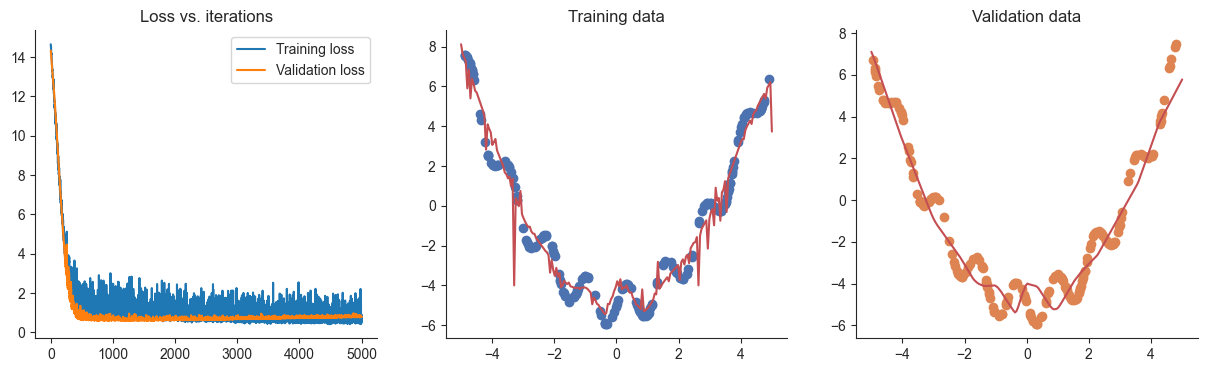

In [21]:
def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        model.train()
        output = model(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        valid_loss = loss_func(model(xvalid), yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

    return losses, valid_losses

model = nn.Sequential(
            Dropout(),
            LinearKaiming(1, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, 1),
            )

# Test our model build
test_build(model, LinearKaiming, dropout_type=Dropout, type='normal')

lr = 0.003
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)